# Importing Libraries #

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Load Dataset #

In [ ]:
train_path = "/content/train_data (1).txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

In [ ]:
print(train_data.describe())

                                 Title    Genre  \
count                            54214    54214   
unique                           54214       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  


In [ ]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None


In [ ]:
print(train_data.isnull().sum())

Title          0
Genre          0
Description    0
dtype: int64


In [ ]:
# Load the test data
test_path = "/content/test_data (1).txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


# EDA & Visualization #

<ipython-input-7-bf49a689a75a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='Genre', order=train_data['Genre'].value_counts().index, palette=palette, ax=ax1)
<ipython-input-7-bf49a689a75a>:12: UserWarning: 
The palette list has fewer values (10) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=train_data, x='Genre', order=train_data['Genre'].value_counts().index, palette=palette, ax=ax1)
<ipython-input-7-bf49a689a75a>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right', fontsize=12)
<ipython-input-7-bf49a689a75a>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fa

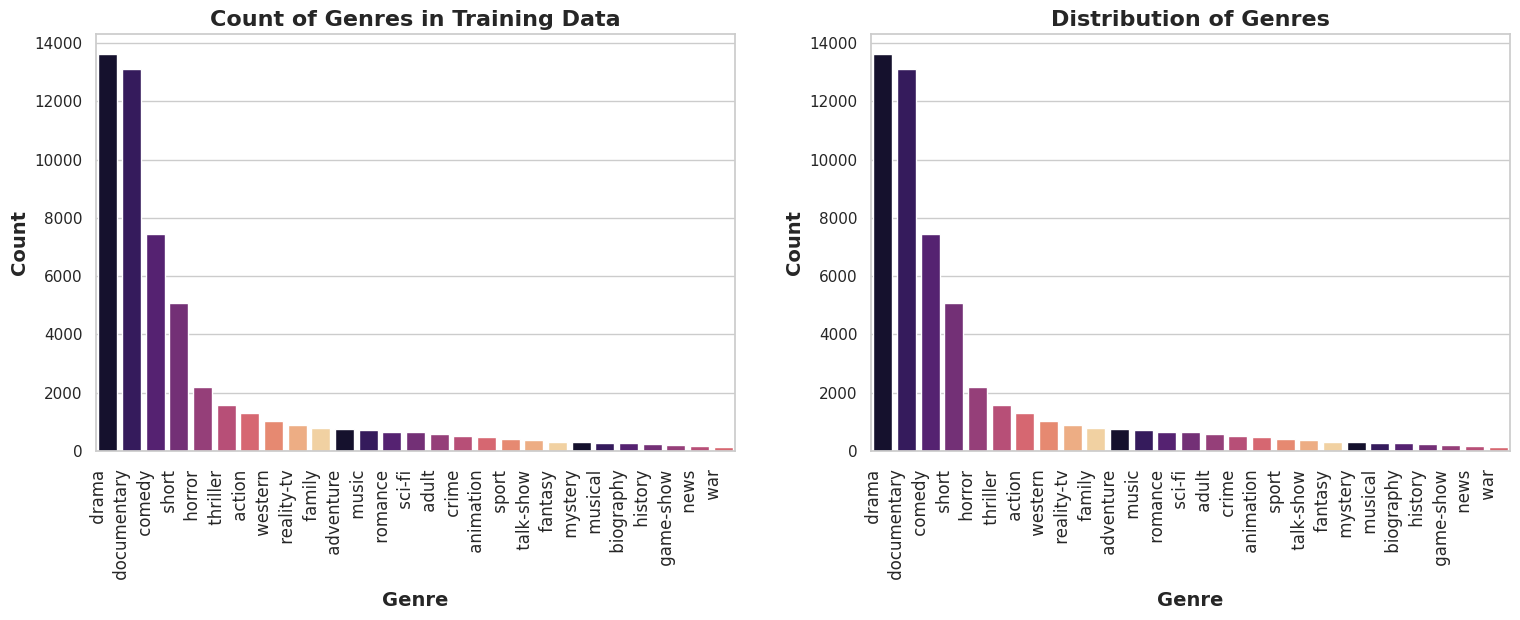

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
palette = sns.color_palette("magma", n_colors=10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Vertical count plot for genre distribution
sns.countplot(data=train_data, x='Genre', order=train_data['Genre'].value_counts().index, palette=palette, ax=ax1)
ax1.set_ylabel('Count', fontsize=14, fontweight='bold')
ax1.set_xlabel('Genre', fontsize=14, fontweight='bold')
ax1.set_title('Count of Genres in Training Data', fontsize=16, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right', fontsize=12)

# Plot 2: Vertical bar plot for genre distribution with value counts
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette=palette, ax=ax2)
ax2.set_ylabel('Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Genre', fontsize=14, fontweight='bold')
ax2.set_title('Distribution of Genres', fontsize=16, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='right', fontsize=12)


plt.tight_layout(pad=3.0)
plt.show()


#  Data Preprocessing and Text Cleaning #

In [ ]:
# Initialize the stemmer and stop words
nltk.download('stopwords')
nltk.download('punkt')
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Preprocessing

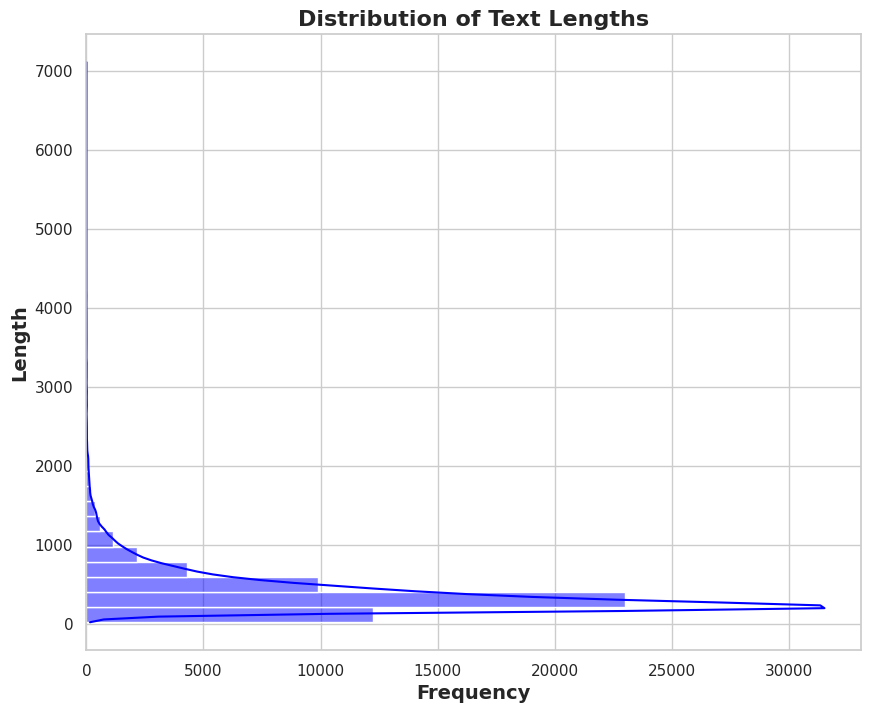

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)

# Create a horizontal histogram for the text length distribution
plt.figure(figsize=(10, 8))
sns.histplot(data=train_data, y='length_Text_cleaning', bins=37, kde=True, color='blue')


plt.ylabel('Length', fontsize=14, fontweight='bold')
plt.xlabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Text Lengths', fontsize=16, fontweight='bold')


plt.show()


#  Text Vectorization Using TF-IDF #

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])


#  Naive Bayes #

In [ ]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)


accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))


Validation Accuracy: 0.44526422576777647
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 # Make Predictions on the Test Data #

In [ ]:
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

# New Dataset (Predicted)

In [ ]:
test_data.to_csv('predicted_genres.csv', index=False)

print(test_data)

          Id                             Title  \
0          1             Edgar's Lunch (1998)    
1          2         La guerra de papá (1977)    
2          3      Off the Beaten Track (2010)    
3          4           Meu Amigo Hindu (2015)    
4          5                Er nu zhai (1955)    
...      ...                               ...   
54195  54196   "Tales of Light & Dark" (2013)    
54196  54197      Der letzte Mohikaner (1965)    
54197  54198              Oliver Twink (2007)    
54198  54199                Slipstream (1973)    
54199  54200        Curitiba Zero Grau (2010)    

                                             Description  \
0       L.R. Brane loves his life - his car, his apar...   
1       Spain, March 1964: Quico is a very naughty ch...   
2       One year in the life of Albin and his family ...   
3       His father has died, he hasn't spoken with hi...   
4       Before he was known internationally as a mart...   
...                                    

# SVM

In [ ]:
# Checking if 'Text_cleaning' and 'Genre' columns exist in the data
if 'Text_cleaning' not in train_data.columns or 'Genre' not in train_data.columns:
    raise KeyError("'Text_cleaning' or 'Genre' not found in the dataset.")


In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data text (Text_cleaning)
X = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])
y = train_data['Genre']


In [ ]:
# Split the data into training and validation sets (for classification)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize and train the Support Vector Classifier (SVC)
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [ ]:
# Make predictions on the validation set using SVC
y_pred_svm = svm_classifier.predict(X_val)


accuracy_svm = accuracy_score(y_val, y_pred_svm)
print("Validation Accuracy (SVM):", accuracy_svm)
print(classification_report(y_val, y_pred_svm))


Validation Accuracy (SVM): 0.5957760767315319


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

      action        0.55      0.33      0.42       263
       adult        0.74      0.38      0.50       112
   adventure        0.45      0.19      0.27       139
   animation        0.58      0.11      0.18       104
   biography        0.00      0.00      0.00        61
      comedy        0.54      0.61      0.57      1443
       crime        0.33      0.02      0.04       107
 documentary        0.68      0.85      0.75      2659
       drama        0.55      0.78      0.65      2697
      family        0.45      0.10      0.16       150
     fantasy        0.50      0.03      0.05        74
   game-show        0.88      0.55      0.68        40
     history        0.00      0.00      0.00        45
      horror        0.68      0.63      0.65       431
       music        0.63      0.47      0.54       144
     musical        0.33      0.02      0.04        50
     mystery        1.00      0.02      0.04        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Transform the test data using the trained TF-IDF vectorizer
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

# Make predictions on the test data
X_test_predictions = svm_classifier.predict(X_test)

# Save predictions in the test_data DataFrame
test_data['Predicted_Genre'] = X_test_predictions


In [ ]:
# Assuming 'length_Text_cleaning' is a calculated field in train_data
y_regression = train_data['length_Text_cleaning']


In [ ]:
# Split the data into training and validation sets for regression
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)


# SVR

In [ ]:
svr_classifier = SVR(kernel='linear')
svr_classifier.fit(X_train_reg, y_train_reg)

SVR(kernel='linear')

In [ ]:
# Make predictions on the validation set using SVR
y_pred_reg = svr_classifier.predict(X_val_reg)


regression_accuracy = svr_classifier.score(X_val_reg, y_val_reg)
print("Validation R^2 Score (SVR):", regression_accuracy)


Validation R^2 Score (SVR): -0.04504761378468025


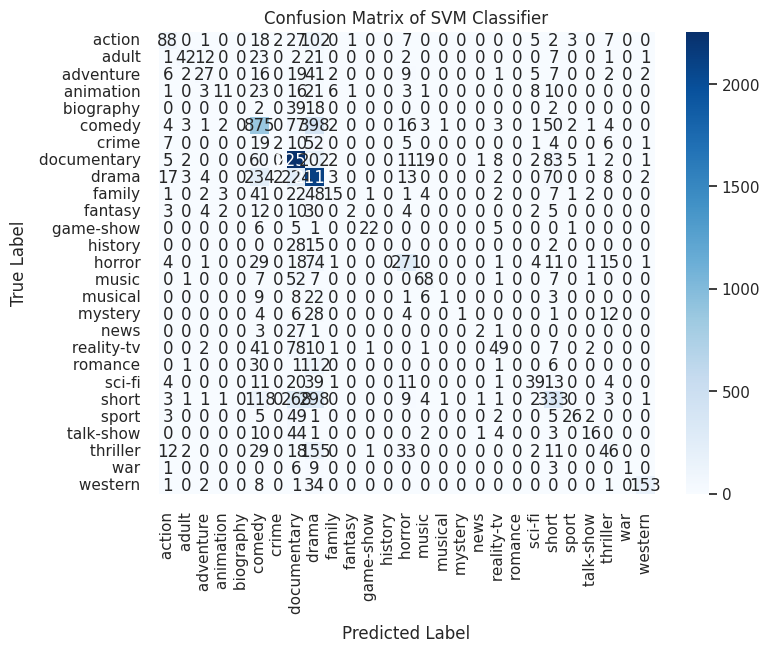

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_svm)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of SVM Classifier')
plt.show()


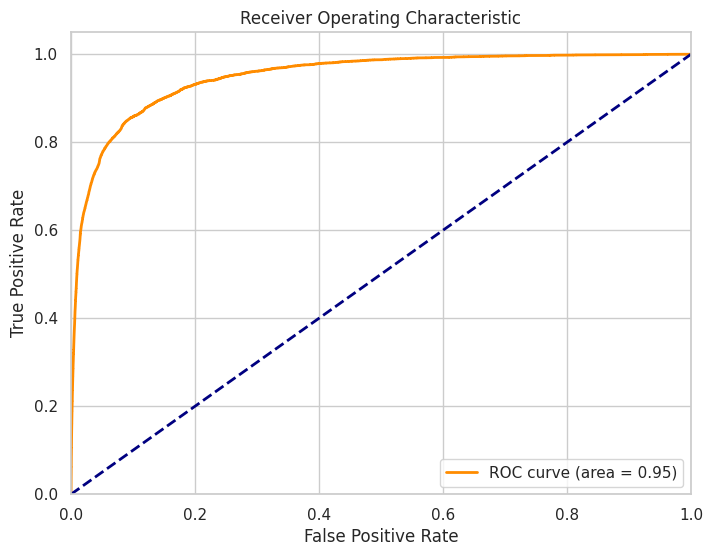

In [ ]:
# Binarize the labels for multi-class (useful if you have more than two genres)
y_val_bin = label_binarize(y_val, classes=svm_classifier.classes_)

# Get decision function scores for ROC curve
y_score = svm_classifier.decision_function(X_val)

# Calculate the ROC curve and AUC score for each class
fpr, tpr, _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# COMPARISION

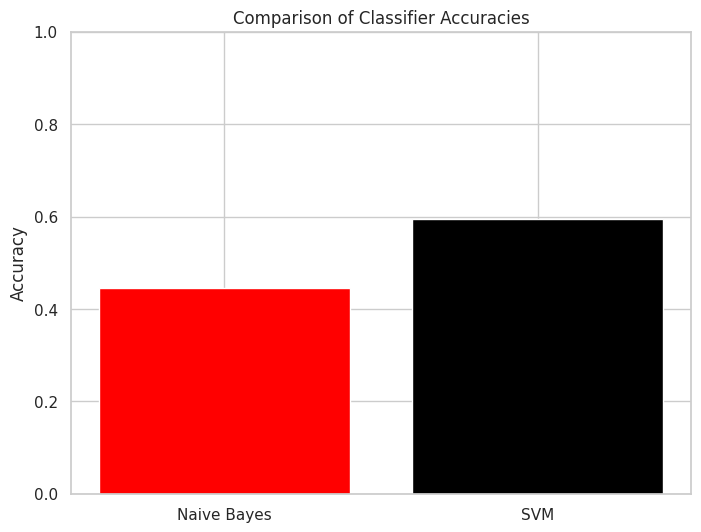

Naive Bayes Accuracy: 0.44526422576777647
SVM Accuracy: 0.5957760767315319


In [ ]:

nb_accuracy = accuracy_score(y_val, y_pred)


svm_accuracy = accuracy_score(y_val, y_pred_svm)

# Visualize the comparison of accuracies
classifiers = ['Naive Bayes', 'SVM']
accuracies = [nb_accuracy, svm_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(classifiers, accuracies, color=['red', 'black'])
plt.title('Comparison of Classifier Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
